# TM10007 Assignment template

In [6]:
# Run this to use from colab environment
# !pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

  Preparing metadata (setup.py) ... done


## Importing packages

In [7]:
# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn

# Classifiers
from sklearn import model_selection
from sklearn import metrics

# Preprocessing steps
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [8]:
## Data loading functions. Uncomment the one you want to use
# from worcgist.load_data import load_dat
from worclipo.load_data import load_data
#from worcliver.load_data import load_data
#from ecg.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')



The number of samples: 115
The number of columns: 494


# Plotting data in histogram
To determine data distribution

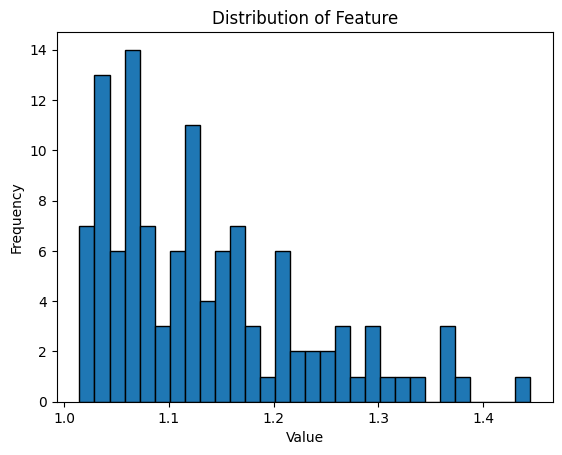

In [13]:
# if Gaussian distribution, take mean for filling empty cells (later in script)
# if not Gaussion distribution (and outliers or skewed), take median for filling empty cells (later in script)

plt.hist(data.iloc[:, 15], bins=30, edgecolor='k') # Change number of colum to see distribution
plt.title('Distribution of Feature')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [10]:
print(data.head())

                  label  PREDICT_original_sf_compactness_avg_2.5D  \
ID                                                                  
Lipo-001_0  liposarcoma                                  0.368434   
Lipo-002_0  liposarcoma                                  0.660571   
Lipo-003_0       lipoma                                  0.365191   
Lipo-004_0  liposarcoma                                  0.372210   
Lipo-005_0       lipoma                                  0.369120   

            PREDICT_original_sf_compactness_std_2.5D  \
ID                                                     
Lipo-001_0                                  0.262371   
Lipo-002_0                                  0.179013   
Lipo-003_0                                  0.157712   
Lipo-004_0                                  0.169761   
Lipo-005_0                                  0.167485   

            PREDICT_original_sf_rad_dist_avg_2.5D  \
ID                                                  
Lipo-001_0       

# Inspecting data

In [11]:
## uncomment following lines to print different info
# print(data.head())
# print(data.info())
# print(data.describe()) # Gives 8 metrics per column [8x494]

# Check missing values
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])

# Pipeline for numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values
    ('scaler', StandardScaler()),  # Scale features
    ('pca', PCA(n_components=0.95))  # Reduce dimensionality (nog kijken welke waarden)
])

# Apply the transformation to the feature set (excluding the label column)
X = data.drop('label', axis=1) # haal kolom van label eraf
Y = data['label'] # voor y neem je alleen kolom met label

X_preprocessed = numeric_transformer.fit_transform(X)
print(X_preprocessed)


Series([], dtype: int64)
[[  3.69308699  10.49965385   8.12652172 ...  -0.14012688  -0.18474327
    1.24139976]
 [ -4.56127894   2.81882473  -7.840514   ...   1.63287141   1.38134925
   -1.52803909]
 [ -0.74152394   8.56443472   0.86427269 ...   0.10569603   1.22296131
   -0.7835249 ]
 ...
 [ -4.07252116   3.20510508   7.39819921 ...  -0.56923872  -0.41247159
   -2.87638164]
 [  2.92986516  -5.37845493   7.16185485 ...   1.10432961  -0.65658447
    1.31493125]
 [-11.36513284 -13.00480223  -7.77865287 ...   1.82404703   0.12141449
   -1.78605994]]
